In [1]:
!git clone https://github.com/aub-mind/arabert.git
!pip install -q transformers
!pip install -q datasets
!pip install -q farasapy
!pip install -q pyarabic
!pip install -q emoji
!pip install nltk
!pip install gensim

Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 600 (delta 38), reused 45 (delta 30), pack-reused 535
Receiving objects: 100% (600/600), 9.14 MiB | 8.77 MiB/s, done.
Resolving deltas: 100% (339/339), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (s

In [ ]:
def unique(list_inp,list_cl):
  res_list = []
  cls=[]
  for i in range(len(list_inp)): 
      if list_inp[i] not in res_list: 
          res_list.append(list_inp[i])
          cls.append(list_cl[i]) 
          
  return res_list,cls

[[1, 2, 3], [1, 2]]

In [ ]:
cls

[['1', '2', '3'], ['1', '2']]

## import bibliothéque

In [ ]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments
from pandas import DataFrame
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec, FastText
import pandas as pd
import numpy as np
import re
from sklearn.utils import shuffle
from keras.layers import *
from keras.models import Model
import matplotlib.pyplot as plt
from arabert.preprocess import ArabertPreprocessor
from transformers import AutoTokenizer, AutoModel
from arabert.preprocess import ArabertPreprocessor
from arabert import preprocess
#from arabert.preprocess_arabert import never_split_tokens, 
from farasa.segmenter import FarasaSegmenter
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import collections
import tensorflow
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.layers import Embedding

In [ ]:
import json
import ast

# Dataset

In [ ]:
from bs4 import BeautifulSoup as bs
from bs4.element import Comment
import pandas as pd
import numpy as np
import requests
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def xmltosentences(file_path):
  content = []
  # Read the XML file
  with open(file_path, "r") as file:
      # Read each line in the file, readlines() returns a list of lines
      content = file.readlines()
  # Combine the lines in the list into a string
  content = "".join(content)
  bs_content = bs(content, "lxml")
  child = bs_content.find_all("utterance")
  classes=[]
  sentences=[]
  for chil in child:
    ch=chil.find_all('token')
    if len(ch)!=0:
      sentences.append([x['value'] for x in ch])
      classes.append([x['concept'] for x in ch])
  return sentences,classes
  

In [ ]:
import glob
path_files=glob.glob("/content/drive/MyDrive/projet_mémoire/Corpus annoté XML/*")

In [ ]:
classes_xml=[]
sentences_xml=[]
for path in path_files:
  classes_xml=classes_xml+xmltosentences(path)[1]
  sentences_xml=sentences_xml+xmltosentences(path)[0]


In [ ]:
Train=pd.read_table('/content/drive/MyDrive/projet_mémoire/Corpus_Entrainement_Annote_CRF_28.data',names=['mot', 'label'],header=None)
Test=pd.read_table('/content/drive/MyDrive/projet_mémoire/Corpus_Test_Corpus_26_et_13.data',names=['mot', 'label'],header=None)

In [ ]:
def read_data(path_file):
  
  with open(path_file) as f:
      contents = f.read()
     # file.append(contents)
  contents=contents.replace('\ufeff', '')
  contents=contents.split('\n\n\n')
  contents=[x.split('\n') for x in contents]
  classes=[]
  sentences=[]
  for i in range(len(contents)):
    snt=[]
    cls=[]
    for j in list(filter(None, contents[i])): #list(filter(None, file[i])) pour suprimer le vide dans la liste  ;exemple :['عشره\tB-Ticket_Type', 'سنين\tI-Ticket_Type', '', '']
      lll=j.split('\t')
      s=lll[0]
      c=lll[1]
      cls.append(c)
      snt.append(s)
    classes.append(cls)
    sentences.append(snt)
  return sentences,classes

In [ ]:
train_sentences,train_classes=read_data('/content/drive/MyDrive/projet_mémoire/Corpus_Entrainement_Annote_CRF_28.data')
test_sentences,test_classes=read_data('/content/drive/MyDrive/projet_mémoire/Corpus_Test_Corpus_26_et_13.data')

In [ ]:
train_sentences=train_sentences+sentences_xml
train_classes=train_classes+classes_xml

In [ ]:
random.shuffle(train_sentences)
random.shuffle(train_classes)

In [ ]:
train_sentences,train_classes=unique(train_sentences,train_classes)

In [ ]:
len(max(train_sentences, key=len))

28

In [ ]:
len(max(test_sentences, key=len))
len(max(train_sentences, key=len)) # longuer de la phrase la plus longue

28

## Vectorisation

## Word2vec

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#model1 = gensim.models.Word2Vec(corpus, min_count = 1,size = 100, window = 5)
model2 = gensim.models.Word2Vec(train_sentences, min_count = 1, size = 100,
											window = 5, sg = 1)
model2.wv.get_vector('تونس').shape 

NameError: ignored

## FAST Text

In [ ]:
from gensim.models import FastText
model_fast = FastText(train_sentences, size=20, window=5, min_count=5, workers=4,sg=1)

In [ ]:
model_fast.wv['أعطيني']

array([-1.0152877e-01,  5.1129684e-02, -2.6785174e-01, -3.9250496e-01,
       -6.6561139e-01, -7.8561679e-02, -2.9770714e-01,  3.4985751e-02,
       -4.0732224e-02,  4.2455146e-01, -7.4290849e-02, -1.5072159e-01,
       -4.8983860e-04,  4.2936096e-01,  3.9297479e-01, -1.4884628e-01,
        1.7314525e-01, -3.3077139e-01, -5.9778836e-02,  3.2073343e-01],
      dtype=float32)

## Arabert

In [ ]:
!pip install transformers
!pip install farasapy
!pip install pyarabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02-twitter', do_lower_case=True)


In [ ]:
def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  for i in range(len(data)):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
len_max=len(max(train_sentences, key=len))

In [ ]:
sent_inp,sent_attention=bert_encode(train_sentences,len_max)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
sent_inp.shape

(4141, 28)

In [ ]:
sent_inp

array([[    2,   354,     1, ...,     0,     0,     0],
       [    2,   817,     1, ...,     0,     0,     0],
       [    2,   817,     1, ...,     0,     0,     0],
       ...,
       [    2,     1,   139, ...,     0,     0,     0],
       [    2,     1,   139, ...,     0,     0,     0],
       [    2,     1, 17494, ...,     0,     0,     0]])

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# Preprocess

In [ ]:

from keras.preprocessing.text import Tokenizer

def tokenize(x):
    """Tokenize x.
    
    Parameters:
    x: List of sentences/strings to be tokenized
    
    Returns: 
    Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    return sequences, tokenizer

# **Rembourrage** 
Lors du regroupement de la séquence d'identifiants de mots, chaque séquence doit avoir la même longueur. Étant donné que les phrases sont de longueur dynamique, nous pouvons ajouter un rembourrage à la fin des séquences pour leur donner la même longueur.



In [ ]:

def pad(x, length=None):
    """Pad x.
    Parameters:
    x: List of sequences
    length: Length to pad the sequence to. If None, use length of longest sequence in x
    
    Returns: 
    Padded numpy array of sequences
    """
    if length == None:
        longest_sequence = max(x, key=len)
        return pad_sequences(x, len(longest_sequence), padding='post')
    return pad_sequences(x, length, padding='post')

In [ ]:
def preprocess(y):
    """Preprocess x and y.   
    Parameters:
    x: Feature list of sentences
    y: Label list of sentences
    Returns: 
    Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """ 
    preprocess_y, y_tk = tokenize(y)
    preprocess_y = pad(preprocess_y)
    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return  preprocess_y, y_tk


In [ ]:
def preprocess_s_c(x, y):
    """Preprocess x and y.
    
    Parameters:
    x: Feature list of sentences
    y: Label list of sentences
    
    Returns: 
    Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x,len(max(train_sentences, key=len)))
    preprocess_y = pad(preprocess_y,len(max(train_sentences, key=len)))

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [ ]:
preproc_class, class_tokenizer =    preprocess(train_classes)

In [ ]:

def logits_to_text(logits, tokenizer):
    """Turn logits from a neural network into text using the tokenizer.
    
    Parameters:
    logits: Logits from a neural network
    tokenizer: Keras Tokenizer fit on the labels
    
    Returns: 
    String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = ''
    print ("logist shape: ", logits.shape)

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [ ]:
preproc_sentence, preproc_class, sentence_tokenizer, class_tokenizer =\
    preprocess_s_c(train_sentences, train_classes)

In [ ]:
len(sentence_tokenizer.index_word)

1567

In [ ]:
preproc_sentence.shape

(3456, 28)

In [ ]:
len(class_tokenizer.index_word)

94

In [ ]:
preproc_class.shape

(3456, 28, 1)

In [ ]:
print(preproc_class.shape)

print(preproc_sentence.shape)

(3456, 28, 1)
(3456, 28)


# Models

## RNN 
Un modèle RNN de base est une bonne référence pour les données de séquence

Une époque signifie entraîner le réseau de neurones avec toutes les données d'entraînement pour un cycle. Dans une époque, nous utilisons toutes les données exactement une fois. Une passe avant et une passe arrière ensemble comptent pour une seule passe 

Une époque est composée d'un ou plusieurs lots , où nous utilisons une partie de l'ensemble de données pour entraîner le réseau de neurones. Nous appelons le passage à travers les exemples de formation dans un lot une itération .


In [ ]:
from keras.backend import dropout
def simple_model(input_shape, class_vocab_size,max_len_class):
    """Build and train a basic RNN on x and y.
    Parameters:
    input_shape: Tuple of input shape 
    Returns: 
    Keras model built, but not trained
    """
    learning_rate = 0.01
    inputs = Input(shape=input_shape[1:])

    x = LSTM(28, return_sequences=True)(inputs)

    predictions = TimeDistributed(Dense(class_vocab_size, activation='softmax'))(x)

    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [ ]:
preproc_sentence, preproc_class, sentence_tokenizer, class_tokenizer =\
    preprocess_s_c(train_sentences, train_classes)
print('Data Preprocessed')

Data Preprocessed


In [ ]:
len(class_tokenizer.word_index)

94

In [ ]:
preproc_class.shape

(3456, 28, 1)

In [ ]:
# Reshape the input to work with a basic RNN
tmp_x = pad(preproc_sentence, preproc_class.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_class.shape[-2], 1))

In [ ]:
simple_rnn_model = simple_model(
    tmp_x.shape,
    len(class_tokenizer.word_index)+1,
    preproc_class.shape[1]) # Add 1 because padding introduces 0
simple_rnn_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 28, 28)            3360      
                                                                 
 time_distributed (TimeDistr  (None, 28, 95)           2755      
 ibuted)                                                         
                                                                 
Total params: 6,115
Trainable params: 6,115
Non-trainable params: 0
_________________________________________________________________


In [ ]:
simple_rnn_model.fit(tmp_x, preproc_class, batch_size=4, epochs=30, validation_split=0.3)


Epoch 1/30
605/605 [==============================] - 12s 15ms/step - loss: 0.5485 - accuracy: 0.9036 - val_loss: 0.4900 - val_accuracy: 0.9046
Epoch 2/30
605/605 [==============================] - 11s 17ms/step - loss: 0.4804 - accuracy: 0.9069 - val_loss: 0.4932 - val_accuracy: 0.9058
Epoch 3/30
605/605 [==============================] - 10s 17ms/step - loss: 0.4756 - accuracy: 0.9078 - val_loss: 0.4821 - val_accuracy: 0.9071
Epoch 4/30
605/605 [==============================] - 9s 14ms/step - loss: 0.4720 - accuracy: 0.9083 - val_loss: 0.4751 - val_accuracy: 0.9074
Epoch 5/30
605/605 [==============================] - 11s 18ms/step - loss: 0.4711 - accuracy: 0.9081 - val_loss: 0.4852 - val_accuracy: 0.9062
Epoch 6/30
605/605 [==============================] - 9s 15ms/step - loss: 0.4704 - accuracy: 0.9075 - val_loss: 0.4791 - val_accuracy: 0.9063
Epoch 7/30
605/605 [==============================] - 10s 17ms/step - loss: 0.4666 - accuracy: 0.9085 - val_loss: 0.4797 - val_accuracy: 0

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


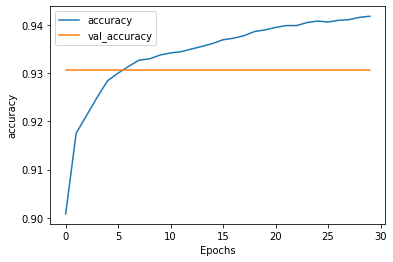

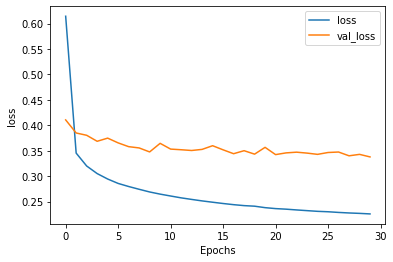

In [ ]:
    plot_graphs(simple_rnn_model.history, 'accuracy')
    plot_graphs(simple_rnn_model.history, 'loss')

In [ ]:
tmp_x[:1][0].shape

(28, 1)

In [ ]:
simple_rnn_model.predict(tmp_x[:1][0]).shape

1/1 [==============================] - 0s 375ms/step


(28, 1, 98)

In [ ]:
preproc_sentence_test, preproc_class_test, sentence_tokenizer_test, class_tokenizer_test =\
    preprocess_s_c(test_sentences, test_classes)
print('Data Preprocessed')

Data Preprocessed


In [ ]:
# Reshape the input to work with a basic RNN
tmp_x_test = pad(preproc_sentence_test, preproc_class_test.shape[1])
tmp_x_test = tmp_x_test.reshape((-1, preproc_class_test.shape[-2], 1))

In [ ]:
tmp_x_test = tmp_x_test.reshape((-1, preproc_class.shape[-2], 1))

In [ ]:
preproc_class_test.shape

(907, 28, 1)

In [ ]:
test_sentences[1]

['ميتين', 'و', 'خمسين']

In [ ]:
simple_rnn_model.evaluate(tmp_x_test,preproc_class_test)

29/29 [==============================] - 0s 3ms/step - loss: 0.8347 - accuracy: 0.9089


[0.8347307443618774, 0.908883273601532]

In [ ]:
simple_rnn_model.predict(tmp_x_test[:1])[0].shape

1/1 [==============================] - 0s 329ms/step


(28, 98)

In [ ]:
# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], class_tokenizer))
print(train_sentences[:1])
print(train_classes[:1])

1/1 [==============================] - 0s 16ms/step
logist shape:  (28, 98)
o i-dep_hour_req b-clarification_req o o b-train b-departure_cpt                     
[['مع', 'وقتاه', 'بالله', 'إي', 'إي', 'تران', 'خروج']]
[['O', 'B-Dep_Hour_Req', 'B-Politenesse', 'O', 'O', 'B-Train', 'B-Departure_Cpt']]


##RNN embeding

In [ ]:
def embed_model(input_shape, output_sequence_length, sentence_vocab_size, class_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 1e-2
    #Config Model
    inputs = Input(shape=input_shape[1:])
    embedding_layer = Embedding(input_dim=sentence_vocab_size,input_length=input_shape[1],output_dim=output_sequence_length,)(inputs)
     
    hidden_layer = GRU(output_sequence_length, return_sequences=True)(embedding_layer)
    outputs = TimeDistributed(Dense(class_vocab_size, activation='softmax'))(hidden_layer)
    
    #Create Model from parameters defined above
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])    
    return model

In [ ]:
preproc_sentence, preproc_class, sentence_tokenizer, class_tokenizer =\
    preprocess_s_c(train_sentences, train_classes)
print('Data Preprocessed')
# Reshape the input to work with a basic RNN
tmp_x = pad(preproc_sentence, preproc_class.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_class.shape[-2], 1))

Data Preprocessed


In [ ]:
tmp_x.shape[:2]

(5779, 28)

In [ ]:
tmp_x=tmp_x.reshape(tmp_x.shape[:2])

In [ ]:
embed_rnn_model = embed_model(
        tmp_x.shape,
        preproc_class.shape[1],
        len(sentence_tokenizer.word_index)+1,
        len(class_tokenizer.word_index)+1)
embed_rnn_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28)]              0         
                                                                 
 embedding (Embedding)       (None, 28, 28)            43904     
                                                                 
 gru (GRU)                   (None, 28, 28)            4872      
                                                                 
 time_distributed_1 (TimeDis  (None, 28, 98)           2842      
 tributed)                                                       
                                                                 
Total params: 51,618
Trainable params: 51,618
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preproc_class=preproc_class.reshape(tmp_x.shape[:2])

(4141, 28)

In [ ]:
embed_rnn_model.fit(tmp_x, preproc_class, batch_size=8, epochs=30, validation_split=0.2)

Epoch 1/30
578/578 [==============================] - 7s 9ms/step - loss: 0.3316 - accuracy: 0.9354 - val_loss: 0.2825 - val_accuracy: 0.9358
Epoch 2/30
578/578 [==============================] - 3s 6ms/step - loss: 0.0997 - accuracy: 0.9770 - val_loss: 0.2307 - val_accuracy: 0.9483
Epoch 3/30
578/578 [==============================] - 4s 7ms/step - loss: 0.0697 - accuracy: 0.9820 - val_loss: 0.2330 - val_accuracy: 0.9508
Epoch 4/30
578/578 [==============================] - 5s 9ms/step - loss: 0.0582 - accuracy: 0.9845 - val_loss: 0.2470 - val_accuracy: 0.9506
Epoch 5/30
578/578 [==============================] - 4s 7ms/step - loss: 0.0525 - accuracy: 0.9854 - val_loss: 0.2557 - val_accuracy: 0.9511
Epoch 6/30
578/578 [==============================] - 4s 6ms/step - loss: 0.0489 - accuracy: 0.9862 - val_loss: 0.2759 - val_accuracy: 0.9509
Epoch 7/30
578/578 [==============================] - 3s 6ms/step - loss: 0.0445 - accuracy: 0.9871 - val_loss: 0.2710 - val_accuracy: 0.9520
Epoch 

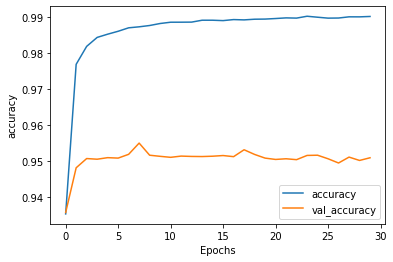

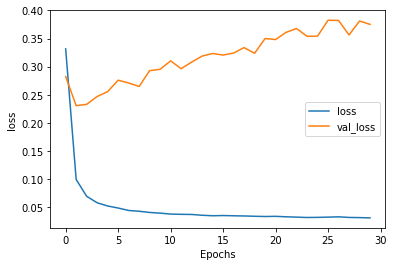

In [ ]:
plot_graphs(embed_rnn_model.history, 'accuracy')
plot_graphs(embed_rnn_model.history, 'loss')

In [ ]:
preproc_sentence_test, preproc_class_test, sentence_tokenizer_test, class_tokenizer_test =\
    preprocess_s_c(test_sentences, test_classes)
print('Data Preprocessed')
# Reshape the input to work with a basic RNN
tmp_x_test = pad(preproc_sentence_test, preproc_class_test.shape[1])
tmp_x_test = tmp_x_test.reshape((-1, preproc_class_test.shape[-2], 1))


Data Preprocessed


In [ ]:
preproc_class_test=preproc_class_test.reshape(preproc_class_test.shape[:2])


In [ ]:
tmp_x_test=tmp_x_test.reshape(tmp_x_test.shape[:2])

In [ ]:
embed_rnn_model.evaluate(tmp_x_test,preproc_class_test)

29/29 [==============================] - 0s 4ms/step - loss: 1.2622 - accuracy: 0.8994


[1.2621570825576782, 0.899393618106842]

## BIRNN
Une restriction d'un RNN est qu'il ne peut pas voir l'entrée future, seulement le passé. C'est là qu'interviennent les réseaux de neurones récurrents bidirectionnels. Ils sont capables de voir les données futures.

In [ ]:
from keras.layers import Bidirectional

In [ ]:
from keras.layers import Bidirectional

def bd_model(input_shape, class_vocab_size):
    """Build and train a bidirectional RNN model on x and y.   
    Parameters:
    input_shape: Tuple of input shape
    output_sequence_length: Length of output sequence

    Returns: 
    Keras model built, but not trained
    """
    learning_rate = 0.01
    inputs = Input(shape=input_shape[1:])

    x = Bidirectional(GRU(512, return_sequences=True))(inputs)
    predictions = TimeDistributed(Dense(class_vocab_size, activation='softmax'))(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [ ]:
preproc_sentence, preproc_class, sentence_tokenizer, class_tokenizer =\
    preprocess_s_c(train_sentences, train_classes)
print('Data Preprocessed')
# Reshape the input to work with a basic RNN
tmp_x = pad(preproc_sentence, preproc_class.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_class.shape[-2], 1))

Data Preprocessed


In [ ]:

bd_rnn_model = bd_model(
    tmp_x.shape,
    # Add 1 because padding introduces 0
    len(class_tokenizer.word_index) + 1) # Add 1 because padding introduces 0
bd_rnn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 28, 1024)         1582080   
 l)                                                              
                                                                 
 time_distributed_2 (TimeDis  (None, 28, 98)           100450    
 tributed)                                                       
                                                                 
Total params: 1,682,530
Trainable params: 1,682,530
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bd_rnn_model.fit(tmp_x, preproc_class, batch_size=16, epochs=30, validation_split=0.2)

Epoch 1/30
289/289 [==============================] - 7s 14ms/step - loss: 0.3802 - accuracy: 0.9192 - val_loss: 0.3820 - val_accuracy: 0.9306
Epoch 2/30
289/289 [==============================] - 3s 9ms/step - loss: 0.2675 - accuracy: 0.9324 - val_loss: 0.4148 - val_accuracy: 0.9306
Epoch 3/30
289/289 [==============================] - 2s 9ms/step - loss: 0.2461 - accuracy: 0.9376 - val_loss: 0.3640 - val_accuracy: 0.9309
Epoch 4/30
289/289 [==============================] - 2s 8ms/step - loss: 0.2351 - accuracy: 0.9390 - val_loss: 0.3580 - val_accuracy: 0.9312
Epoch 5/30
289/289 [==============================] - 2s 8ms/step - loss: 0.2277 - accuracy: 0.9411 - val_loss: 0.3462 - val_accuracy: 0.9319
Epoch 6/30
289/289 [==============================] - 3s 10ms/step - loss: 0.2204 - accuracy: 0.9421 - val_loss: 0.3933 - val_accuracy: 0.9313
Epoch 7/30
289/289 [==============================] - 3s 11ms/step - loss: 0.2172 - accuracy: 0.9430 - val_loss: 0.3330 - val_accuracy: 0.9318
Epo

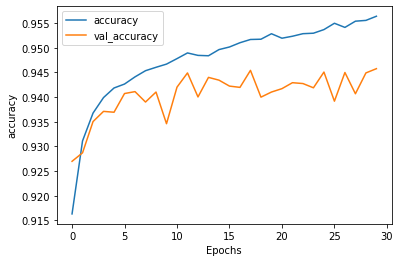

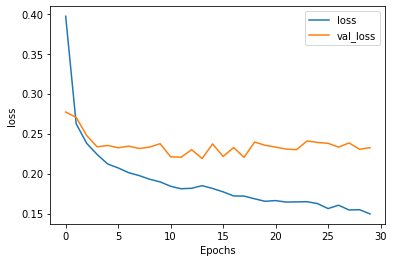

In [ ]:
plot_graphs(bd_rnn_model.history, 'accuracy')
plot_graphs(bd_rnn_model.history, 'loss')

In [ ]:
preproc_sentence_test, preproc_class_test, sentence_tokenizer_test, class_tokenizer_test =\
    preprocess_s_c(test_sentences, test_classes)
print('Data Preprocessed')
# Reshape the input to work with a basic RNN
tmp_x_test = pad(preproc_sentence_test, preproc_class_test.shape[1])
tmp_x_test = tmp_x_test.reshape((-1, preproc_class_test.shape[-2], 1))


Data Preprocessed


In [ ]:
bd_rnn_model.evaluate(tmp_x_test,preproc_class_test)

29/29 [==============================] - 0s 8ms/step - loss: 0.7548 - accuracy: 0.9068


[0.7548370361328125, 0.9068357348442078]

In [ ]:
logits_to_text(bd_rnn_model.predict(tmp_x[:1])[0], class_tokenizer)

1/1 [==============================] - 1s 539ms/step
logist shape:  (28, 98)


'i-politenesse b-dep_hour_req b-politenesse o i-fare b-train b-destination                     '

In [ ]:
# Print prediction(s)
print(logits_to_text(bd_rnn_model.predict(tmp_x[1:2])[0], class_tokenizer))
print(train_sentences[1:2])
print(train_classes[1:2])

1/1 [==============================] - 0s 17ms/step
logist shape:  (28, 98)
b-ticket_numbers i-fare b-train_type                         
[['ثم', 'واحد_آخر', 'تو']]
[['B-Existence_Req', 'B-Train', 'B-Dep_hour']]


## Custum
embedding + birnn

In [ ]:
def model_final(input_shape, output_sequence_length, sentence_vocab_size, class_vocab_size):
    """Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y.
    
    Parameters:
    input_shape: Tuple of input shape
    output_sequence_length: Length of output sequence
    sentence_vocab_size: Number of unique sentence words in the dataset
    class_vocab_size: Number of unique French words in the dataset
    
    Returns: 
    Keras model built, but not trained
    """
    learning_rate = 0.001
    inputs = Input(shape=input_shape[1:])
    encoded = Embedding(sentence_vocab_size, 30)(inputs)
    encoded = Bidirectional(LSTM(28, dropout=0.2))(encoded)
    encoded = Dense(28, activation='relu')(encoded)
    
    decoded = RepeatVector(output_sequence_length)(encoded)
    decoded = Bidirectional(LSTM(28, dropout=0.2, return_sequences=True))(decoded)
    decoded = TimeDistributed(Dense(class_vocab_size))(decoded)
    
    predictions = Activation('softmax')(decoded)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [ ]:
preproc_sentence, preproc_class, sentence_tokenizer, class_tokenizer =\
    preprocess_s_c(train_sentences, train_classes)
print('Data Preprocessed')
# Reshape the input to work with a basic RNN
tmp_x = pad(preproc_sentence, preproc_class.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_class.shape[-2], 1))


Data Preprocessed


In [ ]:
x=preproc_sentence
y=preproc_class
y_tk=class_tokenizer

In [ ]:
x.shape

(4141, 28)

In [ ]:
y.shape[1]

28

In [ ]:
len(y_tk.word_index)

65

In [ ]:
model = model_final(
    x.shape,
    y.shape[1],
    len(sentence_tokenizer.index_word)+1,
    len(y_tk.word_index)+1)
print (model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 28, 30)            47040     
                                                                 
 bidirectional_1 (Bidirectio  (None, 56)               13216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 28)                1596      
                                                                 
 repeat_vector (RepeatVector  (None, 28, 28)           0         
 )                                                               
                                                                 
 bidirectional_2 (Bidirectio  (None, 28, 56)           1276

In [ ]:
model.fit(x, y, batch_size=8, epochs=40, validation_split=0.3)

Epoch 1/40
506/506 [==============================] - 15s 19ms/step - loss: 0.6893 - accuracy: 0.8910 - val_loss: 0.5825 - val_accuracy: 0.9283
Epoch 2/40
506/506 [==============================] - 7s 13ms/step - loss: 0.3865 - accuracy: 0.9041 - val_loss: 0.6246 - val_accuracy: 0.9286
Epoch 3/40
506/506 [==============================] - 8s 16ms/step - loss: 0.3589 - accuracy: 0.9100 - val_loss: 0.6646 - val_accuracy: 0.9288
Epoch 4/40
506/506 [==============================] - 6s 13ms/step - loss: 0.3454 - accuracy: 0.9122 - val_loss: 0.7026 - val_accuracy: 0.9289
Epoch 5/40
506/506 [==============================] - 8s 16ms/step - loss: 0.3365 - accuracy: 0.9141 - val_loss: 0.7265 - val_accuracy: 0.9289
Epoch 6/40
506/506 [==============================] - 6s 13ms/step - loss: 0.3310 - accuracy: 0.9147 - val_loss: 0.7383 - val_accuracy: 0.9290
Epoch 7/40
506/506 [==============================] - 8s 15ms/step - loss: 0.3276 - accuracy: 0.9154 - val_loss: 0.7547 - val_accuracy: 0.929

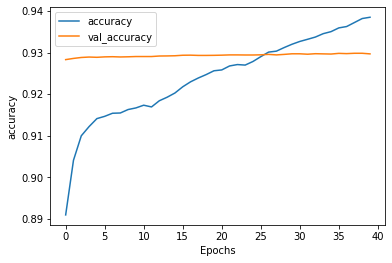

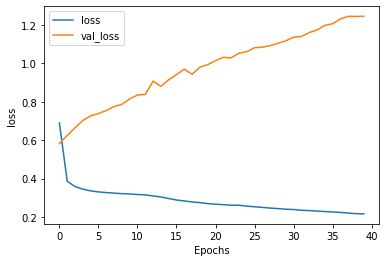

In [ ]:
plot_graphs(model.history, 'accuracy')
plot_graphs(model.history, 'loss')

In [ ]:
preproc_sentence_test, preproc_class_test, sentence_tokenizer_test, class_tokenizer_test =\
    preprocess_s_c(test_sentences, test_classes)
print('Data Preprocessed')
# Reshape the input to work with a basic RNN
tmp_x_test = pad(preproc_sentence_test, preproc_class_test.shape[1])
tmp_x_test = tmp_x_test.reshape((-1, preproc_class_test.shape[-2], 1))

Data Preprocessed


In [ ]:
#preproc_class_test=preproc_class_test.reshape(preproc_class_test.shape[:2])
tmp_x_test=tmp_x_test.reshape(tmp_x_test.shape[:2])

In [ ]:
model.evaluate(tmp_x_test,preproc_class_test)

29/29 [==============================] - 0s 6ms/step - loss: 0.8194 - accuracy: 0.9022


[0.8193976283073425, 0.9022287130355835]

In [ ]:
logits_to_text(model.predict(tmp_x[2:3])[0], class_tokenizer)

1/1 [==============================] - 1s 1s/step
logist shape:  (28, 98)


'b-dep_hour b-dep_hour b-dep_hour b-clarification_req                        '

In [ ]:
print(train_sentences[2:3])
print(train_classes[2:3])

[['ثم', 'واحد_آخر', 'بعد', 'و']]
[['B-Existence_Req', 'B-Train', 'B-Dep_hour', 'O']]
